In [2]:
import pyomo.environ as pyo
import pyomo.gdp as gdp
import numpy as np
import pandas as pd
import math 
import os, sys
from scipy.stats import multivariate_normal

from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,7)
from enum import Enum

CURRENT_DIR = os.path.dirname(os.path.abspath("rare_pattern_detect"))
sys.path.append(os.path.dirname(CURRENT_DIR))

from rare_pattern_detect.patterns import PatternSpace, PatternSpaceType, MIN_AREA
from rare_pattern_detect.minlp_based import minlp_has_rare_pattern
from rare_pattern_detect.rare_pattern_detect import RarePatternDetect
from rare_pattern_detect.pattern_space_utils import draw_largest_bounding_area, draw2dpattern

In [3]:
# # # cmap = plt.get_cmap('viridis')

# # # training_set =  np.array(
# # #     [[0.0, 0.0], [2.0, 0.0], [0.0, 2.0], [2.0, 2.0]]
# # # )
# # training_set = multivariate_normal.rvs(size=(100,2))
# # point_to_be_classified = np.array([[0.25,0.25]])
# # testing_set = multivariate_normal.rvs(size=(10,2))

# with np.load('../ADBench-main/datasets/Classical/33_skin.npz') as data:
#     X = data['X']
#     y = data['y']
#     idx = np.random.permutation(len(X))
#     X,y = X[idx], y[idx]

# # #  number of points is 1831
# # print("number of datapoints is: ",len(y))

# # # number of feature per data point is 21
# # print("number of feature per data point is: ", len(X[0]))


# TRAINING_LIMIT = 100
# FEATURES = 2

# X = X[:TRAINING_LIMIT,:FEATURES]
# y = y[:TRAINING_LIMIT]

# training_set = X[:TRAINING_LIMIT]
# training_labels = y[:TRAINING_LIMIT]

In [4]:
# points_outside_of_largest_bounding_area = 0
# indeces = []
# predictions = []

# mu, epsilon, delta = 0.1, 0.1, 0.1
# N, d = training_set.shape
# v = 2 * d 
# min_area = 63.0 # MIN_AREA 
# print("min_area: ", min_area)
# print(f"N={N} , d={d}, vc={v}")

# lba = np.zeros((d,2), dtype=float)
# for i in np.arange(0,d,1):
#     lba[i] = np.array(
#         [
#             np.min(training_set[:, i]) - 1e-2, 
#             np.max(training_set[:, i]) + 1e-2
#         ]
#     )

# for i, point_to_be_classified in enumerate(training_set): # testing_set
#     print(f"------- itr: {i} -------")
    
#     minlp_model, classification_result = minlp_has_rare_pattern(
#         point_to_be_classified,
#         training_set,
#         PatternSpace(
#             type = PatternSpaceType.AXIS_ALIGNED_HYPER_RECTANGLES, 
#             cutoff = min_area if min_area != None else 0.1
#         ),
#         mu,
#         debugging_minlp_model=True,
#     )
    
#     print("Classification result: ",classification_result)
#     predictions.append(classification_result)
    
#     ax = plt.gca()
#     if minlp_model is not None:
#         result = (
#             mu,
#             classification_result,
#             minlp_model
#         )
#         included_points = minlp_model.extract_points_included_in_pattern()
#         calculated_pattern = minlp_model.extract_pattern()
#         area_calculated_pattern = np.prod(np.apply_along_axis(lambda i: i[1] - i[0], axis=1, arr=calculated_pattern))
#         print("area_calculated_pattern: ", area_calculated_pattern)
#         # assert area_calculated_pattern is not None, "area of minimized pattern is None"
#         # assert area_calculated_pattern >= 0, "area of minimized pattern is negative"
#         largest_bounding_area = minlp_model.largest_bounding_area
#         [plt.scatter(
#             x=p[0], 
#             y=p[1], 
#             marker="o", 
#             s=200, 
#             label=f"included point: {np.argwhere(training_set == p)[0,0]}") for _, p in enumerate(included_points)
#         ]
#         plt.legend([f"area of calculated pattern: {area_calculated_pattern}"])
#         draw_largest_bounding_area(largest_bounding_area, ax)
#         draw2dpattern(calculated_pattern, ax, classification_result, minlp_model.minimized_f_hats, len(training_set))
#         plt.legend(bbox_to_anchor=(1.1, 1.1))
#     else:
#         print(f"---> !! minlp model is none and classification results: {classification_result} !! ")
#         draw_largest_bounding_area(lba, ax)
#         ax.legend()
#         points_outside_of_largest_bounding_area += 1 
#         indeces.append(i)

#     plt.scatter(x=training_set[:,0], y=training_set[:,1])
#     plt.scatter(
#         x=point_to_be_classified[0], 
#         y=point_to_be_classified[1], 
#         marker="x",  
#         s=200, 
#         label="target") 
#     plt.legend()
#     plt.show()

# print("-- END __")
# print("Points that lie outside of the largest bounding area defined by the training set: ",points_outside_of_largest_bounding_area) 
# print("indices of the points: ", indeces)

# Experiment: Prediction using Isolation Forest and comparison with the minlp solver

In [5]:
# from sklearn.ensemble import IsolationForest

# clf = IsolationForest(random_state=0).fit(X)
# r = clf.predict(X) # -1 anomalie
# r = np.where(r==1, r, False).astype(bool)
# # print("r: ",r)

# count_similar_predictions = np.count_nonzero(r == predictions)
# percentage_similar_predictions = count_similar_predictions/len(X)

# len(X), count_similar_predictions,  percentage_similar_predictions


# Testing the solver on more than two features

In [6]:
# with np.load('../ADbench-main/datasets/Classical/6_cardio.npz') as data:
#     X = data['X']
#     y = data['y']

# TRAINING_LIMIT = 200
# TESTING_LIMIT = 10
# FEATURES = 2

# X = X[:,:FEATURES]

# training_set = X[:TRAINING_LIMIT]
# training_labels = y[:TRAINING_LIMIT]

# # slicing
# testing_set = X[TRAINING_LIMIT:-1:300]
# testing_labels = y[TRAINING_LIMIT:-1:300]

# rpd = RarePatternDetect(
#     delta=0.1,
#     tau=0.1,
#     epsilon=0.1,
#     pattern_space = PatternSpace(
#         PatternSpaceType.AXIS_ALIGNED_HYPER_RECTANGLES, 
#         cutoff = 0.1
#     )
# )

# # print("testing_set: ", testing_set)
# rpd.fit(training_set)

# preds = [rpd.predict_score(point_to_be_classified) for _, point_to_be_classified in enumerate(testing_set)]

# print("--- RESULTS ---")
# print("predictions: ", preds)

# Evaluating the performance (AUROC) on 300 points with 3 features

In [7]:
# # Loading the data
with np.load('../ADBench-main/datasets/Classical/33_skin.npz') as data:
    X = data['X']
    y = data['y']
    idx = np.random.permutation(len(X))
    X,y = X[idx], y[idx]

TRAINING_LIMIT = 100 # 0
FEATURES = 3
X = X[:TRAINING_LIMIT,:FEATURES]
y = y[:TRAINING_LIMIT]

In [8]:
# for 0 points 95.0 # 46.28 # 63.0917 # 30.0914 for 300 points # 63.0917 for 100 points # 48.8 for 200 points
min_area = 63.0917 # 34.23 # for 500 points 
epsilon = 0.001

# Creating a range of min areas
# min_areas = np.linspace(start=0.1,stop=40.0,num=4)

predictions_list = []
print(f"num datapoints: {len(y)}")

# for i, ma in enumerate(min_areas):
    # print(f"––– ––– ––– new round: i={i}, min_area:{ma}  ––– ––– –––")

rpd = RarePatternDetect(
    delta=0.1,
    tau=0.001,
    epsilon=epsilon,
    pattern_space = PatternSpace(
        PatternSpaceType.AXIS_ALIGNED_HYPER_RECTANGLES, 
        cutoff = min_area
    )
)
rpd.fit(X)
preds = []
f_hats = []
for i, point_to_be_classified in enumerate(X):
    if i % 10 == 0: 
        print(f"----- {i} data points processed -----")
    model, prediction = rpd.predict_score(point_to_be_classified)
    preds.append(prediction)
    f_hats.append(model.minimized_f_hats[i])
    #print("f_hats: ", f_hats)



num datapoints: 100
cutoff (min_area):  63.0917
----- 0 data points processed -----
    functionality.  (deprecated in 6.4.2) (called from
    /Users/p392827/Desktop/PDG/porsche-research/pac-learning/pac-
    venv/lib/python3.9/site-
    packages/pyomo/contrib/mindtpy/initialization.py:154)
----- 10 data points processed -----
----- 20 data points processed -----
----- 30 data points processed -----
----- 40 data points processed -----
----- 50 data points processed -----
----- 60 data points processed -----
----- 70 data points processed -----
----- 80 data points processed -----
----- 90 data points processed -----


In [9]:
f_hats

[0.08219137614848972,
 0.07968477557041825,
 0.08022576349226884,
 0.08797347618233223,
 0.08210822125095388,
 0.09130334921990943,
 0.08124987453120397,
 0.0925923099785959,
 0.08886900438621936,
 0.10101753096282806,
 0.09050529132286043,
 0.1580673753824693,
 0.1410796344340759,
 0.11244436561984628,
 0.08307472449893875,
 0.0826396247770034,
 0.07259112562416084,
 0.08244101455556467,
 0.13715955778953776,
 0.16855749816450238,
 0.07997937185288313,
 0.080112954245734,
 0.08249981651961037,
 0.0960184062189019,
 0.08600785798574719,
 0.11206133521340456,
 0.06319237652516324,
 0.13128203536784955,
 0.10687835236927132,
 0.06706173002557518,
 0.07755460677232201,
 0.08343899592402139,
 0.0,
 0.07806924648122275,
 0.08192631941561274,
 0.1682452396590265,
 0.08000075515207344,
 0.08437489869451972,
 0.07838605129379306,
 0.09035451331583848,
 0.0,
 0.11268220418651052,
 0.14168448132117945,
 0.09766424826733708,
 0.08317561123197166,
 0.09735365407963051,
 0.08004558449170868,
 0.080

In [12]:
# creating a range of taus
taus = [0.00001, 0.0001, 0.001, 0.01 , 0.1, 0.2, 0.3, 0.5, 1.0] # np.linspace(start=0.1,stop=1.0,num=5)

for i, tau in enumerate(taus):
    print(f"––– ––– ––– new round: i={i}, tau:{tau}  ––– ––– –––")
    
    predictions = np.asarray(f_hats) < (tau + (epsilon/2))
    predictions_list.append([tau + (epsilon/2), min_area, predictions])

    preds = np.where(predictions==1, predictions, False).astype(bool)
    count_similar_predictions = np.count_nonzero(y == preds)
    per_similar_predictions = count_similar_predictions/len(y)
    print(f" correct results: {count_similar_predictions},  percentage: {per_similar_predictions}")

––– ––– ––– new round: i=0, tau:1e-05  ––– ––– –––
 correct results: 70,  percentage: 0.7
––– ––– ––– new round: i=1, tau:0.0001  ––– ––– –––
 correct results: 70,  percentage: 0.7
––– ––– ––– new round: i=2, tau:0.001  ––– ––– –––
 correct results: 70,  percentage: 0.7
––– ––– ––– new round: i=3, tau:0.01  ––– ––– –––
 correct results: 70,  percentage: 0.7
––– ––– ––– new round: i=4, tau:0.1  ––– ––– –––
 correct results: 31,  percentage: 0.31
––– ––– ––– new round: i=5, tau:0.2  ––– ––– –––
 correct results: 27,  percentage: 0.27
––– ––– ––– new round: i=6, tau:0.3  ––– ––– –––
 correct results: 27,  percentage: 0.27
––– ––– ––– new round: i=7, tau:0.5  ––– ––– –––
 correct results: 27,  percentage: 0.27
––– ––– ––– new round: i=8, tau:1.0  ––– ––– –––
 correct results: 27,  percentage: 0.27


auroc:  0.4794520547945206
auroc:  0.4794520547945206
auroc:  0.49238964992389656
auroc:  0.49238964992389656
auroc:  0.5
auroc:  0.5
auroc:  0.5
auroc:  0.4794520547945206
auroc:  0.4794520547945206
auroc:  0.4794520547945206
auroc:  0.4794520547945206
auroc:  0.49238964992389656
auroc:  0.5
auroc:  0.5
auroc:  0.5
auroc:  0.5


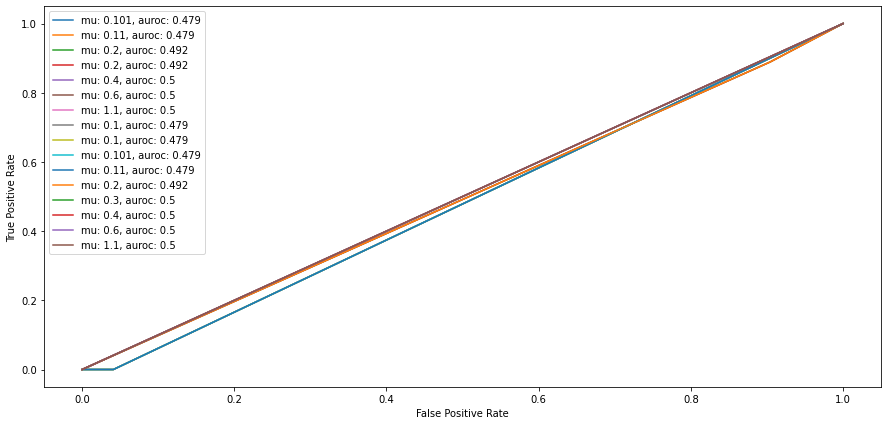

In [13]:
from sklearn import metrics
#print(predictions_list)
for i, (tau,_,p) in enumerate(predictions_list):
    #print("p:", i, p)
    auc = metrics.roc_auc_score(y, p)

    # Recall that a model with an AUC score of 0.5 is no better than a model that performs random guessing.
    print("auroc: ",auc)

    fpr, tpr, _ = metrics.roc_curve(y, p)
    
    #create ROC curve
    plt.plot(fpr,tpr, label=f"mu: {np.round(tau+(epsilon/2), 3)}, auroc: {np.round(auc,3)}")
    plt.legend(loc="upper left")
    #print(fpr,tpr)

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [50]:
# import sympy
# #from sympy import *
# from sympy.abc import x
# from sympy import solve_rational_inequalities, Poly, Symbol

# #x = Symbol('x', real=True)

# N = 100
# v = 2*3
# delta = 0.1
# epsilon = 0.1


# solve_rational_inequalities(
#     [[
#         (Poly(x**2), Poly((1/N) * (256/(epsilon**2)) * ( v * sympy.log((256/(epsilon**2)) * (1/(x**2))) + sympy.log(8/delta))), '>=')
#     ]]
# )



ValueError: too many values to unpack (expected 2)